In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from scipy import stats

In [6]:
def plot_actual_vs_forecast(data_df):
    """
    Plots the actual and forecast data from the given DataFrame.

    Parameters:
    data_df (pd.DataFrame): DataFrame containing the actual and forecast data.
    """
    # Identify actual and forecast columns
    actual_columns = [col for col in data_df.columns if not col.startswith('Forecast_')]
    forecast_columns = [col for col in data_df.columns if col.startswith('Forecast_')]

    # Remove 'Forecast_' prefix from forecast columns for matching
    forecast_columns = [col.replace('Forecast_', '') for col in forecast_columns]

    # Filter only the matching pairs
    matching_columns = [col for col in actual_columns if col in forecast_columns]

    # Create subplots
    n_pairs = len(matching_columns)
    fig, axes = plt.subplots(nrows=n_pairs+1, ncols=2, figsize=(15, 5 * (n_pairs+1)))

    # First row: Load (kW)
    axes[0, 0].plot(data_df.index, data_df['Load (kW)'], label='Load (kW)')
    axes[0, 0].set_title('Load (kW)')
    axes[0, 0].legend()
    axes[0, 1].axis('off')  # Hide the second subplot in the first row

    # Subsequent rows: actual and forecast pairs
    for i, col in enumerate(matching_columns, start=1):
        axes[i, 0].plot(data_df.index, data_df[col], label=col)
        axes[i, 0].set_title(col)
        axes[i, 0].legend()
        
        forecast_col = 'Forecast_' + col
        axes[i, 1].plot(data_df.index, data_df[forecast_col], label=forecast_col)
        axes[i, 1].set_title(forecast_col)
        axes[i, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [7]:
data_df = pd.read_csv('../data/interim/covid_dataset.csv', parse_dates=['Time'], index_col='Time')

In [8]:
# Drop columns that are not needed based on our EDA
columns_to_drop = ['Humidity (%)','Pressure_kpa', 'Cloud Cover (%)', 'Forecast_Cloud Cover (%)', 'Forecast_Pressure_kpa']
data_df = data_df.drop(columns=columns_to_drop)

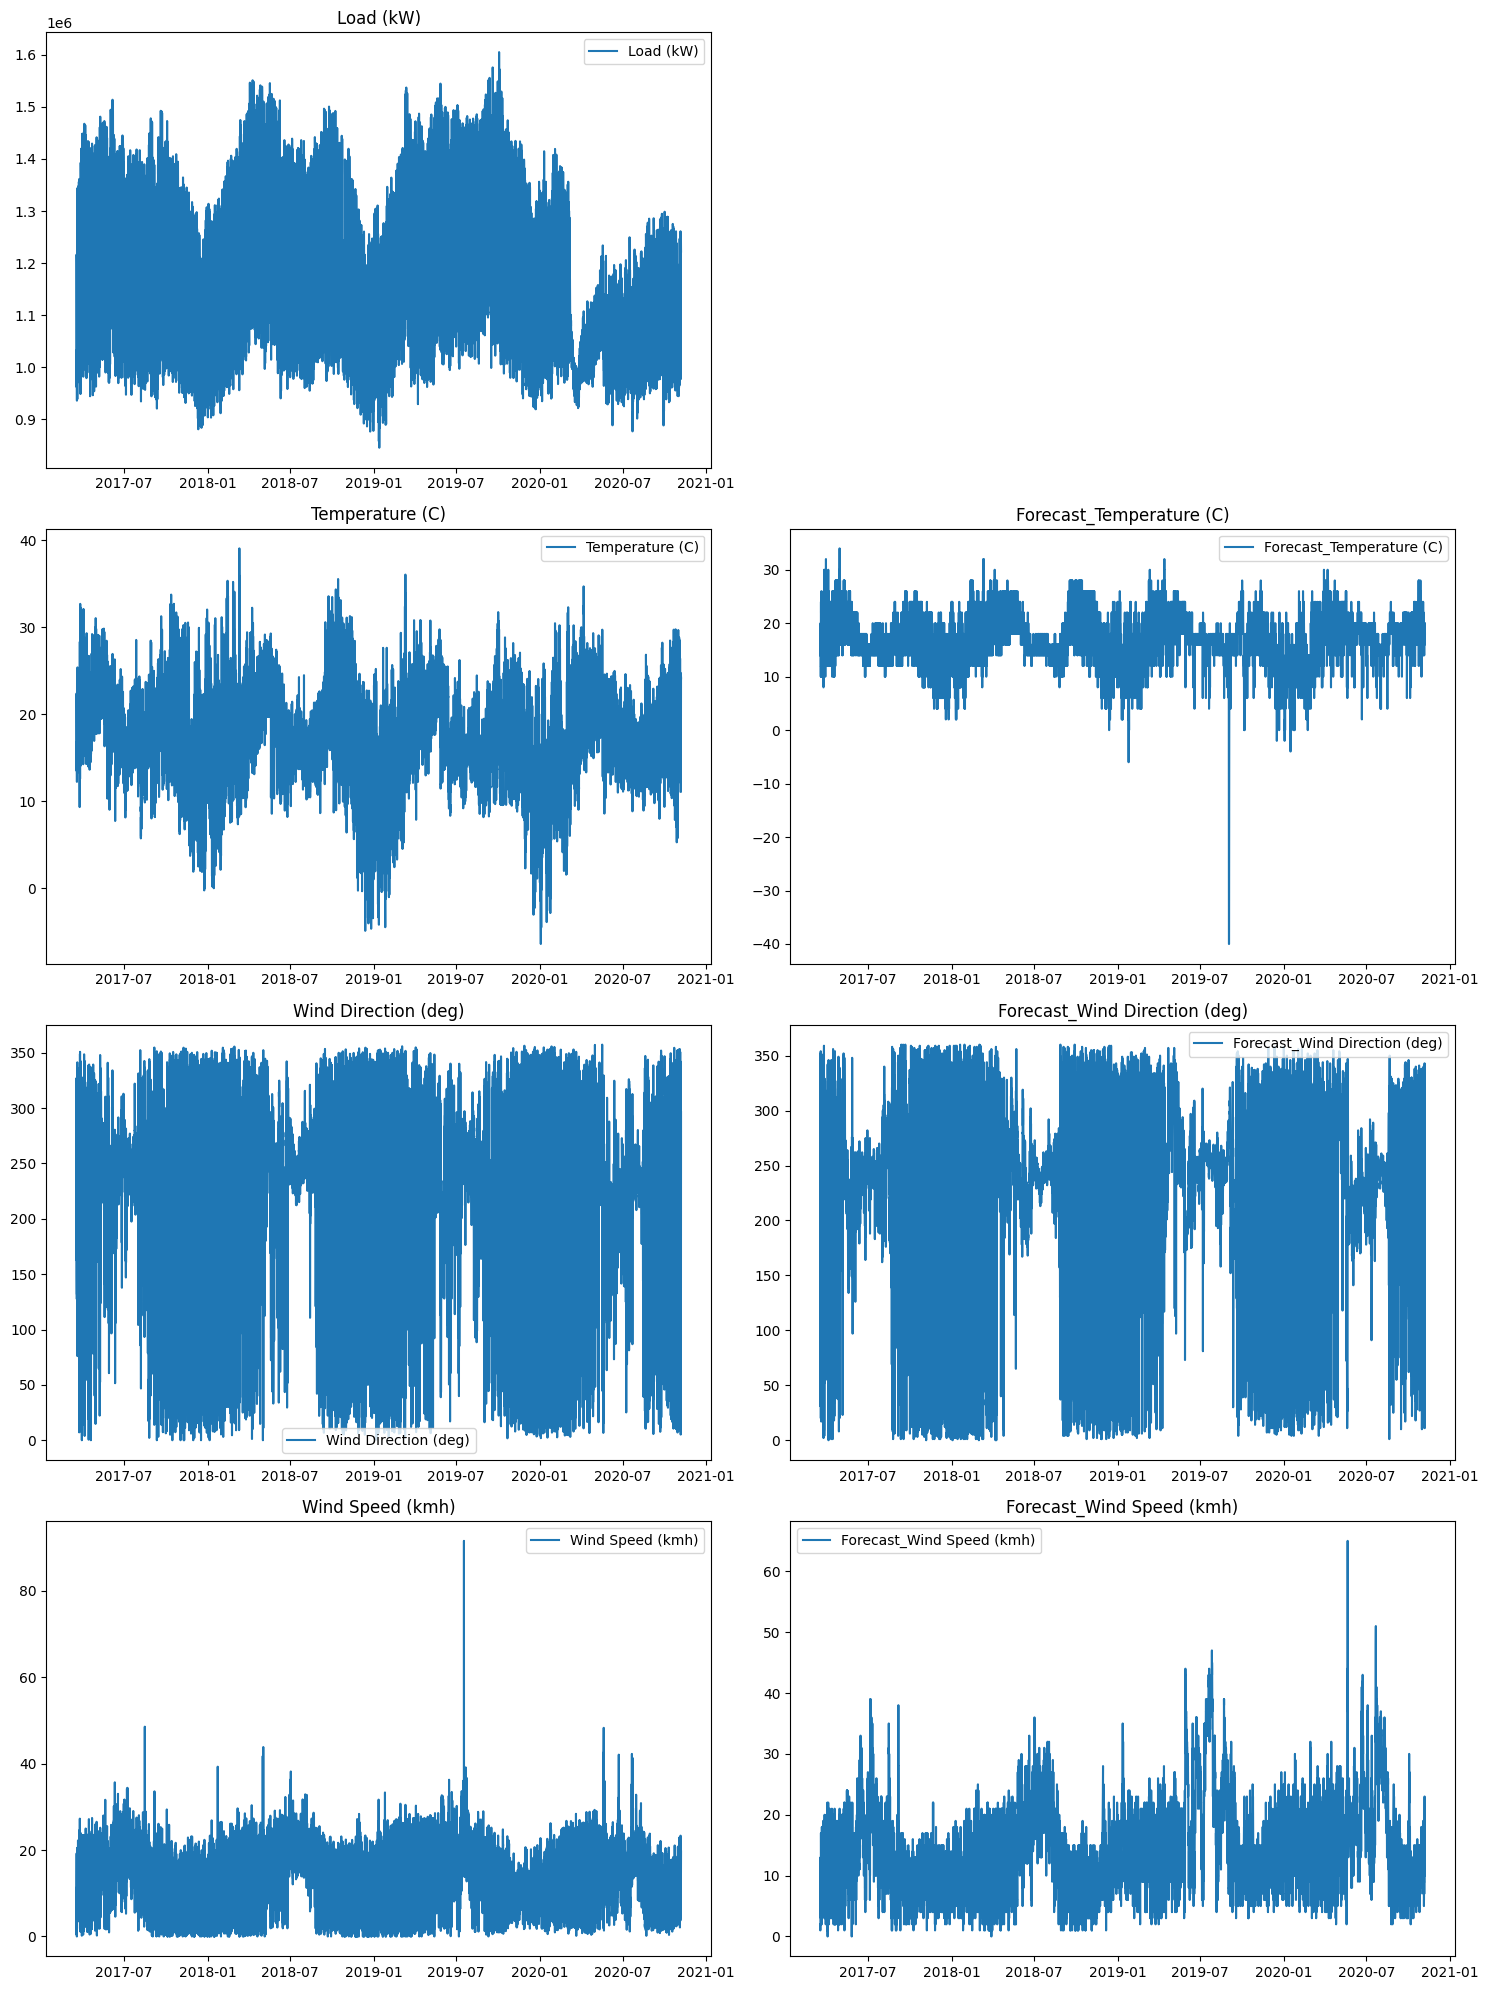

In [9]:
plot_actual_vs_forecast(data_df)

In [10]:
data_df.describe()

,Load (kW),Temperature (C),Wind Direction (deg),Wind Speed (kmh),Forecast_Temperature (C),Forecast_Wind Direction (deg),Forecast_Wind Speed (kmh)
count,3.191200e+04,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000,31912.000000
mean,1.152567e+06,17.000056,212.137643,12.945737,16.558536,216.202463,13.932502
std,1.506257e+05,5.631804,91.639080,6.682953,4.761297,93.016518,7.602707
min,8.454714e+05,-6.418114,0.000000,0.000000,-40.000000,0.000000,0.000000
25%,1.031650e+06,13.656886,134.750000,7.828437,14.000000,169.000000,8.000000
50%,1.114812e+06,16.976886,240.000000,12.286875,16.000000,242.000000,12.000000
75%,1.259393e+06,20.671886,284.625000,18.066562,20.000000,284.000000,18.000000
max,1.605192e+06,39.066886,357.375000,91.497500,34.000000,360.000000,65.000000


## Remove outliers using z-score method with threshold =3 

In [11]:
# Fix outliers
# Calculate Z-scores
z_scores = np.abs(stats.zscore(data_df))

# Set a threshold for Z-scores
threshold = 3

# Identify outliers
outliers = z_scores > threshold

# Replace outliers with the column mean
data_df = data_df.mask(outliers, data_df.mean(), axis=1)


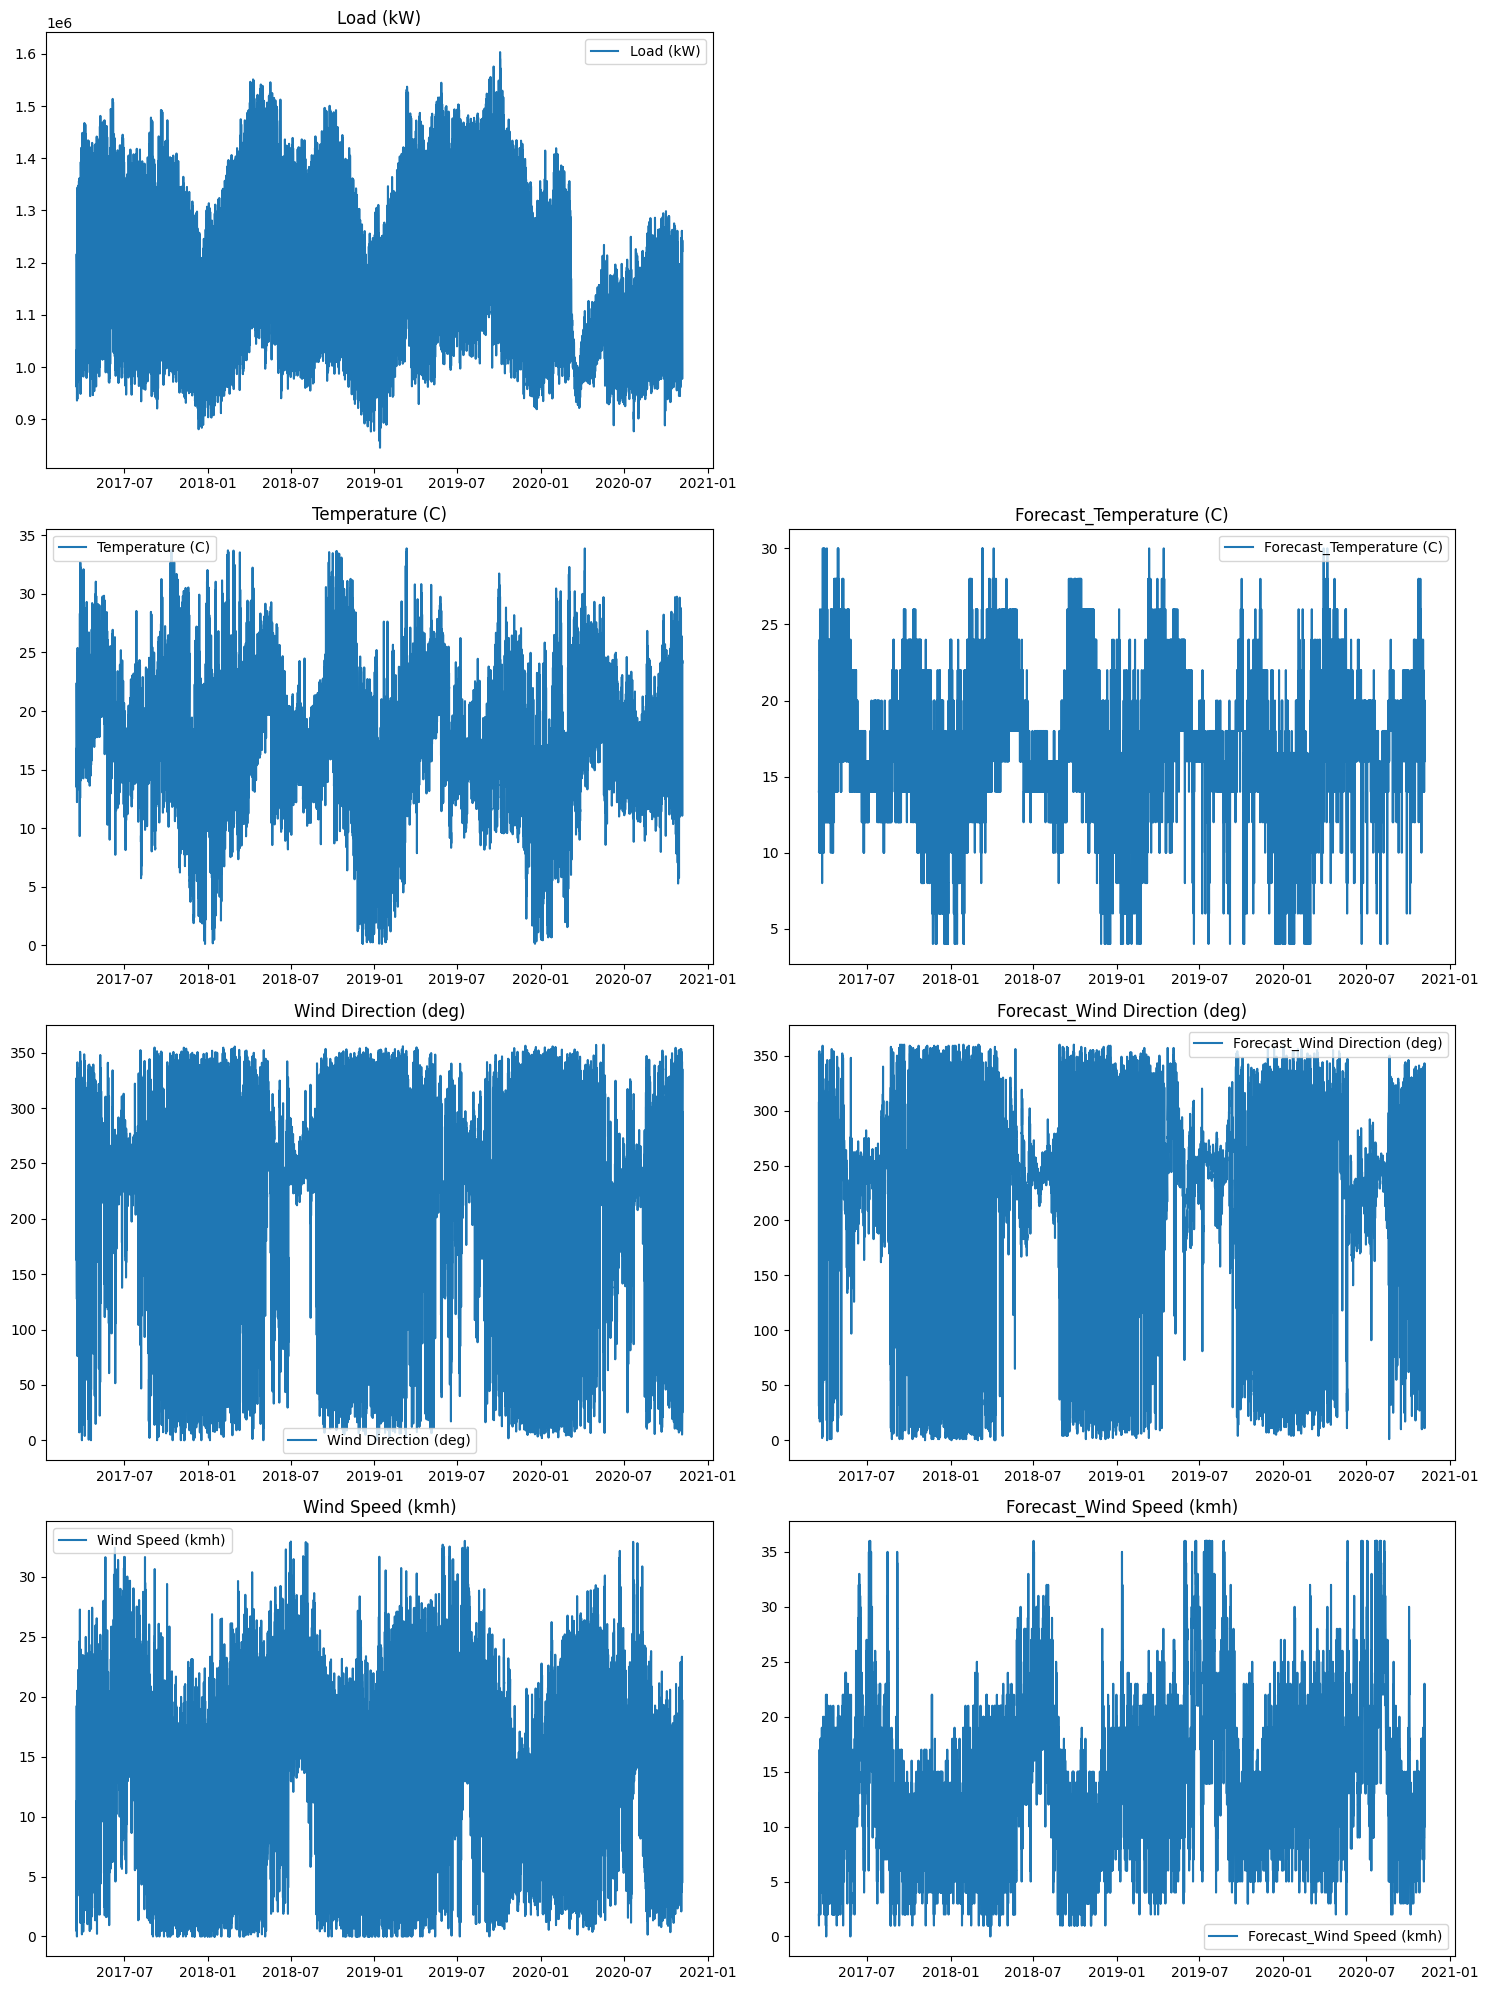

In [12]:
# plot data after outlier removal
plot_actual_vs_forecast(data_df)

In [13]:
data_df.to_csv('../data/processed/covid-data/covid_dataset_final.csv')

## Save dataset that also contains hour of the day pattern

In [14]:
hour_of_day_col = data_df.index.hour
data_df['hour_of_day_sin'] = np.sin(2 * np.pi * hour_of_day_col / 24)
data_df['hour_of_day_cos'] = np.cos(2 * np.pi * hour_of_day_col / 24)

In [16]:
data_df.columns

Index(['Load (kW)', 'Temperature (C)', 'Wind Direction (deg)',
       'Wind Speed (kmh)', 'Forecast_Temperature (C)',
       'Forecast_Wind Direction (deg)', 'Forecast_Wind Speed (kmh)',
       'hour_of_day_sin', 'hour_of_day_cos'],
      dtype='object')

In [17]:
columns_order = ['Temperature (C)', 'Wind Direction (deg)',
       'Wind Speed (kmh)', 'Forecast_Temperature (C)',
       'Forecast_Wind Direction (deg)', 'Forecast_Wind Speed (kmh)',
       'hour_of_day_sin', 'hour_of_day_cos', 'Load (kW)'
]

data_df = data_df[columns_order]

In [18]:
data_df

,Temperature (C),Wind Direction (deg),Wind Speed (kmh),Forecast_Temperature (C),Forecast_Wind Direction (deg),Forecast_Wind Speed (kmh),hour_of_day_sin,hour_of_day_cos,Load (kW)
Time,,,,,,,,,
2017-03-18 00:00:00,16.764386,285.250000,6.253750,14.0,307,2.0,0.000000e+00,1.000000,1.031472e+06
2017-03-18 01:00:00,15.729386,285.000000,9.205000,14.0,215,2.0,2.588190e-01,0.965926,1.007206e+06
2017-03-18 02:00:00,15.816886,316.000000,11.283750,14.0,123,1.0,5.000000e-01,0.866025,9.861084e+05
2017-03-18 03:00:00,15.919386,327.000000,7.168750,14.0,31,1.0,7.071068e-01,0.707107,9.707610e+05
2017-03-18 04:00:00,15.769386,282.250000,0.780000,14.0,138,1.0,8.660254e-01,0.500000,9.622584e+05
...,...,...,...,...,...,...,...,...,...
2020-11-06 11:00:00,21.299386,335.250000,8.280000,18.0,264,11.0,2.588190e-01,-0.965926,1.242830e+06
2020-11-06 12:00:00,22.419386,261.250000,11.466250,20.0,332,12.0,1.224647e-16,-1.000000,1.239480e+06
2020-11-06 13:00:00,22.971886,296.250000,14.507500,20.0,328,14.0,-2.588190e-01,-0.965926,1.234773e+06


In [19]:
data_df.to_csv('../data/processed/covid-data/covid_dataset_final_with_daily_pattern.csv')

# Weather Correction using lstm